In [1]:
!pip install napari aicsimageio tifffile matplotlib scikit-image==0.17.2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import napari
import autocrop as ac

on_colab = 'google.colab' in str(get_ipython())

## Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.

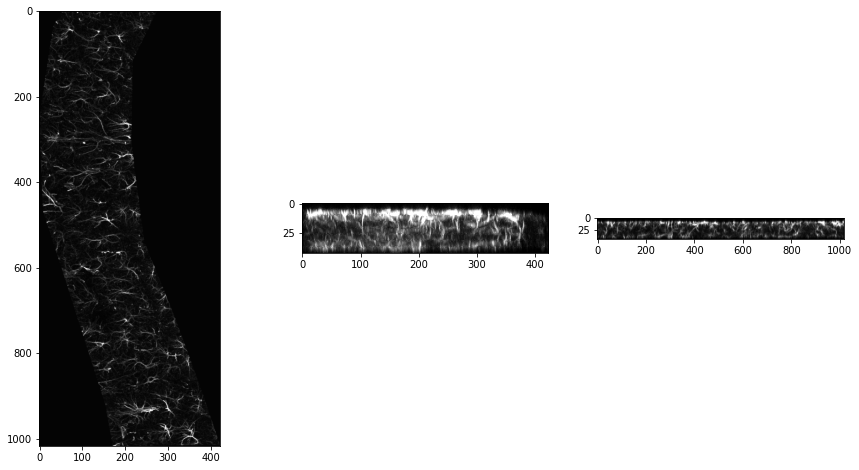

In [3]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/C1-DNSC 8 SEC 1 HILUS-1.tif'

original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)
ac.projectXYZ(original, .5, .5, 1)

## Denoise with Global parameters

### 1. Calibrating Denoisers

In [4]:
denoiser = ac.calibrate_nlm_denoiser(original)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
denoise_parameters

{'h': 0.002121127224933429, 'patch_size': 2, 'patch_distance': 4}

### 2. Denoise with Non-local means using calibrated parameters

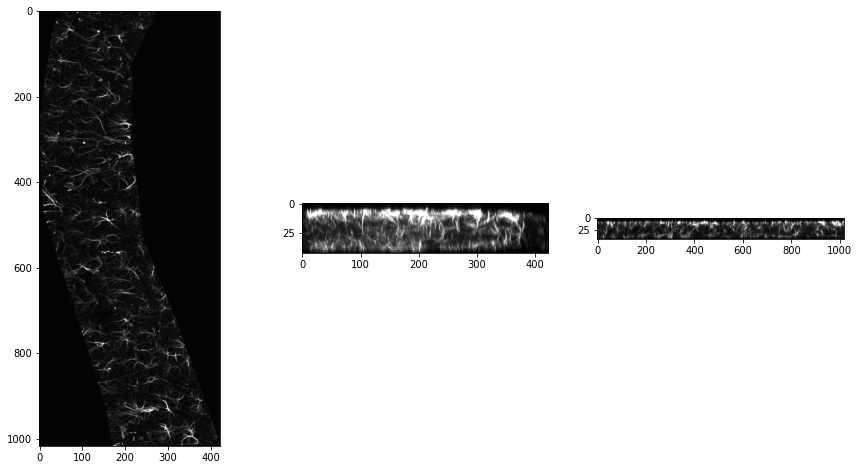

In [5]:
denoised = ac.denoise(original, denoise_parameters)
ac.projectXYZ(denoised, .5, .5, 1)

In [6]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(original, colormap='gray', name='original')
        viewer.add_image(denoised, colormap='inferno', name='denoised')

## Segmentation

### 1. Edge filtering

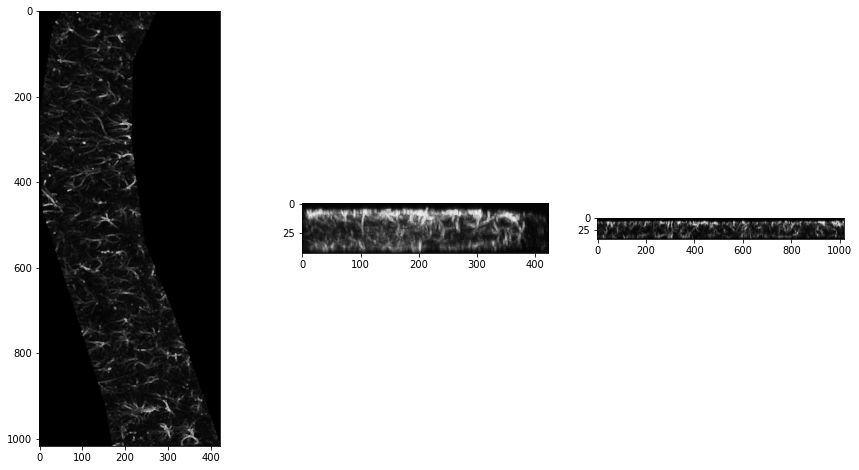

In [7]:
edge_filtered = ac.filter_edges(denoised)
ac.projectXYZ(edge_filtered, .5, .5, 1)

In [8]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(denoised)
        viewer.add_image(edge_filtered, colormap='inferno')

### 2. Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

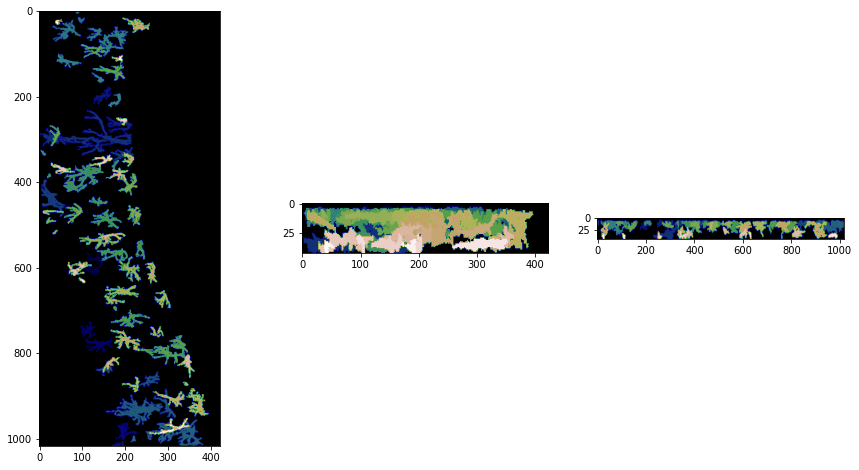

In [9]:
LOW_THRESH = .05
HIGH_THRESH = .45

thresholded = ac.threshold(edge_filtered, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)
ac.projectXYZ(labels, .5, .5, 1, 'gist_earth')

In [10]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(original)
        viewer.add_image(denoised, colormap='inferno')
        viewer.add_image(labels, colormap='gist_earth', gamma=.8)

### 3. Find convex hull that approximates tissue structure

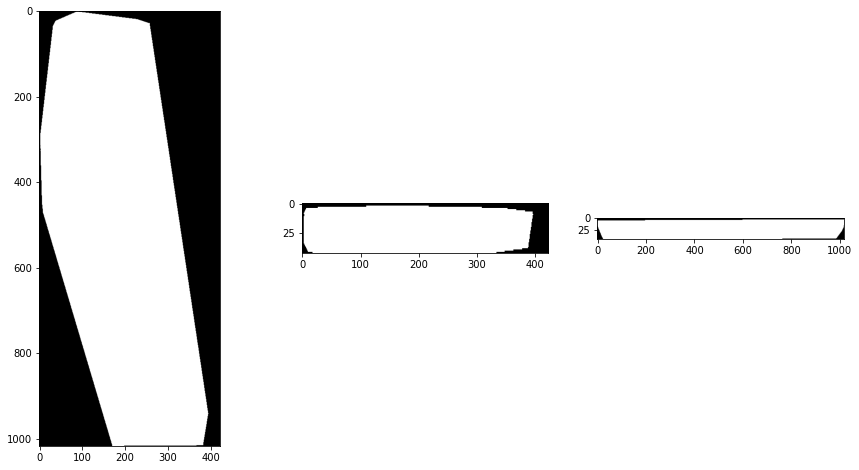

In [11]:
convex_hull = ac.compute_convex_hull(thresholded)
ac.projectXYZ(convex_hull, .5, .5, 1)

In [12]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(denoised)
        viewer.add_image(thresholded, colormap='red')
        viewer.add_image(convex_hull, colormap='yellow')

### 4. Filter segmented individual cells by removing ones in borders

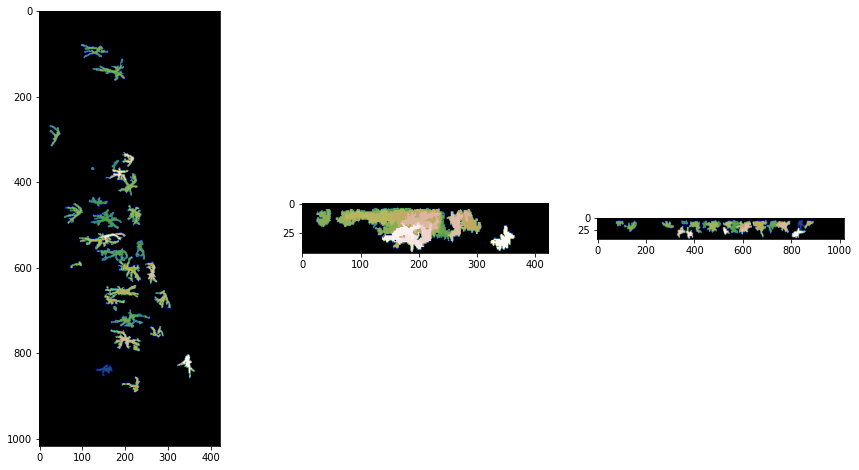

In [13]:
# discard objects connected to border of approximated tissue, potential partially captured
filtered_labels = ac.filter_labels(labels, convex_hull)
ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [14]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(filtered_labels)
        viewer.add_image(labels, colormap='gist_earth')
        viewer.add_image(convex_hull, colormap='yellow')

### 5. Visualize segmented cells to determine cutoff volumes

#### 5.1 Check batches of objects

In [15]:
regions = ac.arrange_regions(filtered_labels)
N_OBJECTS = len(regions)
print(f'{N_OBJECTS} objects detected.')
N_BATCHES = N_OBJECTS // 50 + (N_OBJECTS % 50 > 0)
print(f'There will be {N_BATCHES} batches, set `BATCH_NO` from 0 to {N_BATCHES-1}')

30 objects detected.
There will be 1 batches, set `BATCH_NO` from 0 to 0


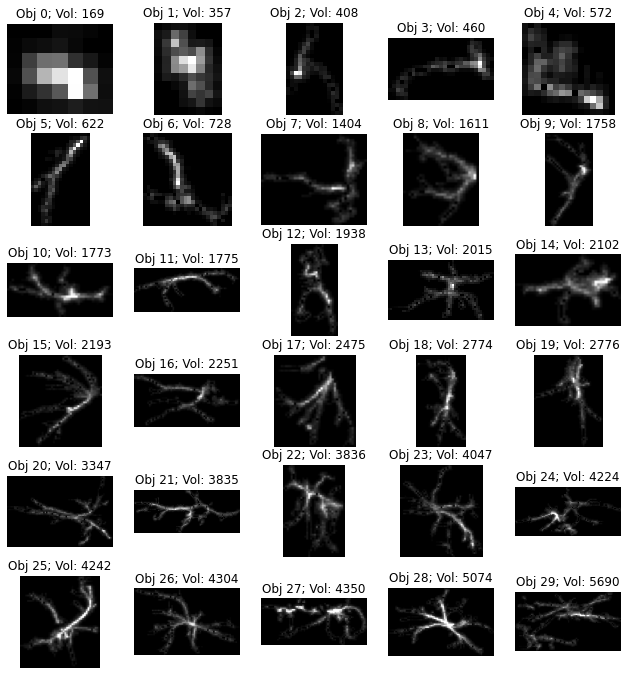

In [16]:
BATCH_NO = 0
ac.project_batch(BATCH_NO, N_BATCHES, N_OBJECTS, regions, denoised)

#### 5.2 Check individual objects
Select individual objects using `OBJ_INDEX`.

Volume of cell at index 21 is: 3835


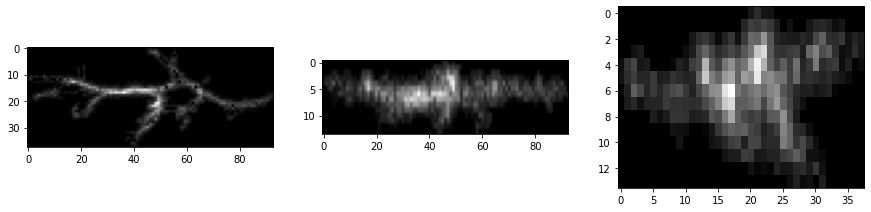

In [17]:
OBJ_INDEX = 21

minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX].bbox

extracted_cell = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
extracted_cell[~regions[OBJ_INDEX].filled_image] = 0.0

print(f'Volume of cell at index {OBJ_INDEX} is: {regions[OBJ_INDEX].area}')
ac.projectXYZ(extracted_cell, .5, .5, 1)

In [18]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(denoised[minz:maxz, miny:maxy, minx:maxx], name='denoised')
        viewer.add_image(regions[OBJ_INDEX].image, colormap='yellow', name='thresholded')
        viewer.add_image(extracted_cell, colormap='inferno')

## Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = 0 for 3D cells, or
- Set `OUTPUT_OPTION` = 1 for Max Intensity Projections.

In [19]:
LOW_VOLUME_CUTOFF = 160  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 5100  # filter cell clusters

OUTPUT_OPTION = 1  # 0 for 3D cells, 1 for Max Intensity Projections

ac.export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, denoised, regions)